# Best Ensemble Model Performance

- Best Performance from - XGBoost
- Best XGB parameters:  {'alpha': 0.1, 'colsample_bytree': 0.6, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.6}
                           
                           
- Best XGB Mean Cross-validation score: 0.9000979280668082
- XGB Train Performance:  0.9958177155979924
- XGB Test Performance:  0.8990642888872433

###### If Std Deviation were to be considered to choose the best model I would say the best model is SVR since it has an equivalent CV score and a much lesser variance. Although the test score is lesser it may be better generalized to new data than the model trained by XGBoost given the lower variance.

- Performance of - SVR
- Best SVR parameters:  {'C': 100, 'coef0': 20, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'} 
                           
- SVR Mean Cross-validation score: 0.90
- SVR Train Performance:  0.9444788521078157
- SVR Test Performance:  0.8768076655482138

# Best Basic Model Performance

- Best Performance from - Lasso with hyperparameter tuning
- Best Lasso parameters:  {'alpha': 10, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'normalize': True, 'positive': True, 'precompute': False, 'selection': 'random', 'warm_start': True}
                           
                           
- Best Lasso Mean Cross-validation score: 0.89
- Lasso Train Performance:  0.9072326965004419
- Lasso Test Performance:  0.8871244754623431

- R-squared: 0.8723755587541305
- Mean Absolute Error (MAE): 18851.654185144293
- Mean Square Error(MSE): 775693617.6638514
- Root Mean Square Error(RMSE): 27851.276769007403

## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [2]:
# load dataset
data = pd.read_csv(r'D:\EverythingDS\DataSets\houseprice.csv')

### Types of variables



In [3]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [4]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [5]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [6]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [7]:
# find continuous variables numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [8]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

### Feature Engineering

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [9]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [10]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [13]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [14]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [15]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [16]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [17]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

# Models

### a) Linear Regression

##### Linear Regression without hyperparameter tuning

In [18]:
# Train a linear regression model, report the coefficients and model performance 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

lr = LinearRegression().fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train, cv = 5)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores))
print()
# Print Co-efficients
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)
print()
# Check test data set performance
print("LR Performance Train: ", lr.score(X_train,y_train))
print("LR Performance Test: ", lr.score(X_test,y_test))
from sklearn import metrics
prediction = lr.predict(X_test)
print()
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Mean Cross-validation scores: [ 8.68335879e-01 -1.63333860e+22  8.76526862e-01  8.98295453e-01
  8.92144253e-01]

lr.coef_: [ 8.85927525e+02  9.75644921e+02  1.42545171e+03  2.42696786e+03
  1.56693816e+03  3.24692479e+02  5.81879561e+02  1.20843642e+03
  1.48451723e+03  2.33407390e+03  1.19468180e+03  1.13660741e+04
  1.26370439e+03  2.05282944e+03  1.11219959e+03 -1.02795026e+03
  1.58283046e+04 -2.87976032e+02 -5.42258305e+03  3.96685877e+03
  3.83205283e+02 -1.05487079e+03  3.20053819e+03 -2.39216924e+03
 -8.64056302e+02  2.87342464e+02  2.68418516e+03  7.01892160e+02
  1.10320795e+02  2.34026895e+03  5.77461978e+02  3.59790087e+03
  1.26233209e+03  5.66404524e+03 -1.47947834e+03  1.92530058e+03
 -2.58202781e+02  7.61273013e+03  2.03532069e+02  1.45836364e+03
  1.19537366e+03 -7.34010025e+02  1.22398147e+04  1.12640063e+04
  4.18413086e+03  5.78194145e+03  2.84259370e+03 -1.31565113e+03
  4.19564807e+03  5.26242437e+03  5.93220195e+02  3.05776071e+03
  3.73937387e+03  3.13011975e+0

#### Linear Regression with hyperparameter tuning

In [19]:
from sklearn.model_selection import GridSearchCV
lr = LinearRegression().fit(X_train,y_train)

#define a list of parameters
params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'n_jobs':[-1]}

lr_gcv = GridSearchCV(lr, params, cv=5, return_train_score = True, scoring='r2')
lr_gcv.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(lr_gcv.best_score_))
print()

#find best parameters
print('Best Linear Regression parameters: ', lr_gcv.best_params_)
print()
# print co-eff

print("LR.coef_:", lr_gcv.best_estimator_.coef_)
print("LR.intercept_:", lr_gcv.best_estimator_.intercept_)
print()
# Check test data set performance

print("LR Train Performance: ", lr_gcv.score(X_train,y_train))
print("LR Test Performance : ", lr_gcv.score(X_test,y_test))
from sklearn import metrics
prediction = lr_gcv.predict(X_test)
print()
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, prediction))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: -6875.24

Best Linear Regression parameters:  {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'normalize': True}

LR.coef_: [ 8.87447130e+02  1.01770145e+03  1.42210870e+03  2.38308495e+03
  1.54992552e+03  3.80803342e+02  5.93982258e+02  1.19349297e+03
  1.49038515e+03  2.30842228e+03  1.18854284e+03  1.13614662e+04
  1.24882507e+03  2.06175662e+03  1.11350037e+03 -1.03812458e+03
  1.58789795e+04 -3.04109123e+02 -5.44842107e+03  3.98104551e+03
  3.78422242e+02 -1.04790176e+03  3.23171163e+03 -2.41432153e+03
 -8.55351317e+02  2.72850001e+02  2.65824485e+03  6.78013639e+02
  1.04885214e+02  2.35842534e+03  5.98376116e+02  3.62422961e+03
  1.20071412e+03  5.69568278e+03 -1.49640621e+03  1.94118728e+03
 -2.29470223e+02  7.62270931e+03  2.27097199e+02  1.46415388e+03
  1.15323064e+03 -7.08218588e+02  1.21691911e+04  1.12710940e+04
  4.18838986e+03  5.78362878e+03  2.85829588e+03 -1.35342715e+03
  4.19069721e+03  5.25643311e+03  5.95851549e+02  3.055

#### Linear Regression with SGD

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
lr_sgd = SGDRegressor().fit(X_train,y_train)

#define a list of parameters
params = {'eta0':[0.1], 'penalty':['l2'], 'alpha':[0.1],
         'l1_ratio':[0.3], 'fit_intercept':[True],
         'learning_rate':['adaptive'],
         'early_stopping':[True,False]}

grid_sgd = GridSearchCV(lr_sgd, params, cv=5, n_jobs=-1, return_train_score = True, scoring='r2')

grid_sgd.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_sgd.best_score_))
print()

#find best parameters
print('Best Linear Regression parameters: ', grid_sgd.best_params_)
print()
# print co-eff

print("LR.coef_:", grid_sgd.best_estimator_.coef_)
print("LR.intercept_:", grid_sgd.best_estimator_.intercept_)
print()
# Check test data set performance

print("LR Train Performance: ", grid_sgd.score(X_train,y_train))
print("LR Test Performance : ", grid_sgd.score(X_test,y_test))

prediction = grid_sgd.predict(X_test)
print()
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, prediction))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: 0.88

Best Linear Regression parameters:  {'alpha': 0.1, 'early_stopping': False, 'eta0': 0.1, 'fit_intercept': True, 'l1_ratio': 0.3, 'learning_rate': 'adaptive', 'penalty': 'l2'}

LR.coef_: [  566.90565398  1188.7663767   1427.38157631  2656.37818181
  1500.33168262   249.37877817   696.33885896  1183.45746761
  1413.14131472  2205.38532367  1255.61606788  9696.93306551
  1215.71696474  1971.84234595  1152.34916131  -621.69761702
 12468.1570024   -484.62648739 -2355.03001983  3106.52973681
   752.67949108  -490.46705128   940.88681074  -414.1166934
  -761.0434297    895.12383295  3480.25884431   685.78787018
  -329.40771942  2734.82791915   444.6214747   3396.93879934
  1385.81556347  5852.89182856 -1155.86792116  1828.4384078
  -249.42458858  7834.43840385   139.83636558  1423.69603025
  1245.60920226  -502.54317338 10549.53676341  9990.77128542
  3657.96908297  6258.09284469  2497.83094697 -1030.38272318
  3792.14290289  4368.15923582   913.6374788

### b) Ridge Regression

##### Ridge Regression without hyperparameter tuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

ridge.fit(X_train, y_train)
# print("Best Mean Cross-validation score: {:.2f}".format(grid_ridge.best_score_))
print()

print("Ridge Train Performance: ", ridge.score(X_train,y_train))
print("Ridge Test Performance:: ", ridge.score(X_test,y_test))
prediction = ridge.predict(X_test)
print()

print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))


Ridge Train Performance:  0.911506182152134
Ridge Test Performance::  0.8751424526508844

R-squared: 0.8595461701862254
Mean Absolute Error (MAE): 20173.45640505862
Mean Square Error(MSE): 858035459.7914636
Root Mean Square Error(RMSE): 29292.242314159965


##### Ridge Regression with hyperparameter tuning

In [23]:
# Train a Ridge regression model, report the coefficients, the best parameters, and model performance 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[100, 120, 125],'fit_intercept':[True,False],
               'normalize':[True,False], 'copy_X':[True, False], 'max_iter':[10]}

grid_ridge = GridSearchCV(ridge, param_ridge, cv=5, return_train_score = True, scoring='r2')
grid_ridge.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_ridge.best_score_))
print()

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)
print()

# print co-eff

print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)
print()

# Check test data set performance

print("Ridge Train Performance: ", grid_ridge.score(X_train,y_train))
print("Ridge Test Performance:: ", grid_ridge.score(X_test,y_test))
print()

# Metrics
prediction = grid_ridge.predict(X_test)
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, prediction))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: 0.88

Ridge parameters:  {'alpha': 120, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10, 'normalize': False}

Ridge.coef_: [  611.0628824   1198.20214482  1437.37773173  2677.67230977
  1495.26730393   254.17877379   684.98667657  1182.86011979
  1404.72124228  2223.79359196  1258.56715507  9704.49396065
  1225.47314506  1967.83214048  1218.39632953  -618.11477407
 12713.71653905  -479.35996705 -2542.30147251  3142.90004255
   726.26382528  -542.33283351  1653.63361435 -1154.19969425
  -792.6306418    895.39827873  3468.25657534   684.95963716
  -313.20359377  2766.15111526   443.20763721  3431.6674931
  1388.07492842  5876.06136473 -1169.13592349  1823.64665478
  -233.50458111  7769.56297187   154.6154598   1415.1433389
  1231.3331523   -513.98866099 10565.72826627  9993.78272512
  3667.04981657  6294.22836006  2506.88469762 -1070.90539282
  3774.5211788   4402.78917008   864.63309175  2817.20013285
  4247.61883843  3798.35357979  2827.01995321 

### c) Lasso regression

##### Lasso Regression with hyperparameter tuning

In [24]:
# Train a Lasso regression model, report the coefficients, the best parameters, and model performance 

from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0)

#define a list of parameters
param_lasso = {'alpha':[5, 10, 20], 'fit_intercept':[True,False], 
               'normalize':[True,False], 'copy_X':[True, False], 'precompute':[True,False],
               'warm_start':[True, False], 'positive':[True, False], 'selection':['random','cyclic'],
               'max_iter':[10000]}

grid_lasso = GridSearchCV(lasso, param_lasso, cv=5, return_train_score = True, scoring='r2')
grid_lasso.fit(X_train, y_train)

# print co-eff
print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)
print()

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_lasso.best_score_))
print()

#find best parameters
print('Lasso parameters: ', grid_lasso.best_params_)
print()

# Check test data set performance
print("Lasso Train Performance: ", grid_lasso.score(X_train,y_train))
print("Lasso Test Performance: ", grid_lasso.score(X_test,y_test))
print()

# Metrics
prediction = grid_lasso.predict(X_test)
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Lasso.coef_: [    0.           848.15317598  1043.67673201  2663.43627759
  1134.13004028     0.           282.67421909   973.09661679
   902.88370251  1997.70312323  1326.76155537 10499.79377804
   905.76494647  1882.62531218  1205.48589123     0.
 15517.96954433     0.             0.          2265.32405639
   129.72117562     0.             0.             0.
     0.             0.          1796.73384361   433.51361156
     0.           894.74157199     0.          3005.57090443
     0.          6572.92855671     0.          1430.12339569
     0.          7754.0716042      0.           773.24576314
  1081.20082564     0.         12346.52962175 11553.32622102
  3162.67282518  5742.19923665  2572.0312759      0.
  2446.00187222  4056.63438615   732.39477367  2416.55338952
  3939.74830885  3233.10416016  2324.02573849  1068.51084905
  1339.43514519     0.             0.             0.
  3381.11165742   255.76555408  1147.15089475     0.
     0.          1078.46334594   952.54236966     0

### d) Polynomial Regression

In [25]:
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe_poly=Pipeline([ 
    ('polynomialfeatures', PolynomialFeatures()),
    
    ('norm_reg', LinearRegression())])

param_poly = {'polynomialfeatures__degree':range(1,3)}

grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5, return_train_score = True, scoring='r2')

grid_poly.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_poly.best_score_))
print()

#find best parameters
print('Polynomial Regression parameters: ', grid_poly.best_params_)
print()

# Check test data set performance
print("Polynomial Regression Train Performance: ", grid_poly.score(X_train,y_train))
print("Polynomial Regression Test Performance: ", grid_poly.score(X_test,y_test))
print()

# Metrics
prediction = grid_poly.predict(X_test)
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: -52364747501089368.00

Polynomial Regression parameters:  {'polynomialfeatures__degree': 2}

Polynomial Regression Train Performance:  0.9999955966028627
Polynomial Regression Test Performance:  -1.9061138988228244e+16

R-squared: -0.0011703097043804789
Mean Absolute Error (MAE): 5419225132577.862
Mean Square Error(MSE): 1.309903446219606e+26
Root Mean Square Error(RMSE): 11445101337339.072


### e) Elastic Net

In [26]:
# Elastic net without hyperparameter tuning

In [27]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet().fit(X_train, y_train)
print("Training set score: {:.2f}".format(elasticnet.score(X_train, y_train)))
print("Test set score: {:.2f}".format(elasticnet.score(X_test, y_test)))

Training set score: 0.90
Test set score: 0.85


In [28]:
# With hyperparameter tuning

In [29]:
elasticnet = ElasticNet(random_state=0)

#define a list of parameters
param_elasticnet = {'alpha':[0.125, 0.13, 0.14],'l1_ratio' :[0.3,0.35], 'max_iter':[1000000], 'fit_intercept':[True,False], 
                'normalize':[True,False], 'copy_X':[True, False],'warm_start':[True, False], 'positive':[True, False]}

# param_elasticnet = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],'fit_intercept':[True,False], 
#                 'normalize':[True,False], 'copy_X':[True, False],'warm_start':[True, False], 'positive':[True, False],
#                 'l1_ratio' :[0.2,0.4,0.6,0.8], 'max_iter':[1000000]}

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=5, return_train_score = True, scoring='r2')
grid_elasticnet.fit(X_train, y_train)

grid_elasticnet_train_score = grid_elasticnet.score(X_train, y_train)
grid_elasticnet_test_score = grid_elasticnet.score(X_test, y_test)

#find best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print()
print('Best cross-validation score:', grid_elasticnet.best_score_)
print()

print('Training set score: ', grid_elasticnet_train_score)
print('Test score: ', grid_elasticnet_test_score)
print()

prediction = grid_elasticnet.predict(X_test)
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best parameters:  {'alpha': 0.125, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.35, 'max_iter': 1000000, 'normalize': False, 'positive': True, 'warm_start': True}

Best cross-validation score: 0.8872382180529321

Training set score:  0.9067225793453365
Test score:  0.8813337138181798

R-squared: 0.8621213694207637
Mean Absolute Error (MAE): 18979.939837090416
Mean Square Error(MSE): 815488399.2800511
Root Mean Square Error(RMSE): 28556.757506412578


### f) KNN Regression

In [30]:
# Without hyperparameter tuning

In [31]:
from sklearn.neighbors import KNeighborsRegressor

knnreg = KNeighborsRegressor().fit(X_train, y_train)
print("Training set score: {:.2f}".format(knnreg.score(X_train, y_train)))
print("Test set score: {:.2f}".format(knnreg.score(X_test, y_test)))

Training set score: 0.88
Test set score: 0.59


In [32]:
# With hyperparameter tuning

In [33]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor().fit(X_train, y_train)
param_knn = {'n_neighbors': [6,7,8]}

#apply grid search
gridknn = GridSearchCV(knn, param_knn, cv=5, return_train_score=True, scoring='r2')

gridknn.fit(X_train, y_train)

#find best parameters
print('Best parameters: ', gridknn.best_params_)
print('Best cross-validation score:', gridknn.best_score_)
print()

print('KNN train score: ', gridknn.score(X_train, y_train))
print('KNN test score: ', gridknn.score(X_test, y_test))

prediction = gridknn.predict(X_test)
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(prediction,y_test))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best parameters:  {'n_neighbors': 7}
Best cross-validation score: 0.8094982197657485

KNN train score:  0.8639346038181245
KNN test score:  0.648087467301915
R-squared: 0.2563737683652123
Mean Absolute Error (MAE): 21448.666340508804
Mean Square Error(MSE): 2418383495.5181713
Root Mean Square Error(RMSE): 49177.062697137284


### g) Decision Tree Regressor 

In [34]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor().fit(X_train,y_train)

#define a list of parameters
params = {'splitter':['best','random'],
         'max_depth': [9,10],
         'min_samples_split': range(2,10)}

grid_dt = GridSearchCV(dt, params, cv=5, n_jobs=-1, return_train_score = True, scoring='r2')

grid_dt.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dt.best_score_))
print()

#find best parameters
print('Best Decision Tree Regression parameters: ', grid_dt.best_params_)
print()

# Check test data set performance
print("Decision Tree Train Performance: ", grid_dt.score(X_train,y_train))
print("Decision Tree Test Performance: ", grid_dt.score(X_test,y_test))

prediction = grid_dt.predict(X_test)
print()
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, prediction))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: 0.77

Best Decision Tree Regression parameters:  {'max_depth': 9, 'min_samples_split': 6, 'splitter': 'best'}

Decision Tree Train Performance:  0.9505842806334412
Decision Tree Test Performance:  0.8231504568996388

R-squared: 0.8197222776254633
Mean Absolute Error (MAE): 22586.369517799547
Mean Square Error(MSE): 1215330448.5770319
Root Mean Square Error(RMSE): 34861.589874488396


### h) SVR

In [35]:
from sklearn.svm import SVR

svr = SVR()
params = [
#     {'kernel':['rbf'], 'C':[75, 100, 125], 'gamma':[0.1], 'epsilon':[.1]},
#           {'kernel':['linear'], 'C':[1,10,100], 'gamma':['auto']},
          {'kernel':['poly'], 'C':[75, 100, 125], 'gamma':['auto'], 'degree':[2,3], 'epsilon':[.1], 'coef0':[19,20,21]},
#           {'kernel': ['sigmoid'],'C': [ 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
]

grid_svr = GridSearchCV(svr, params, cv=5, n_jobs=-1, return_train_score = True, scoring='r2')

grid_svr.fit(X_train, y_train)


# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_svr.best_score_))
print()

#find best parameters
print('Best Support Vector Regression parameters: ', grid_svr.best_params_)
print()

# Check test data set performance
print("Support Vector Regression Train Performance: ", grid_svr.score(X_train,y_train))
print("Support Vector Regression Test Performance: ", grid_svr.score(X_test,y_test))

prediction = grid_svr.predict(X_test)
print()
print("R-squared:",metrics.r2_score(prediction,y_test))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, prediction))
print('Mean Square Error(MSE): {}'.format(mean_squared_error(prediction,y_test)))
print('Root Mean Square Error(RMSE): {}'.format(sqrt(mean_squared_error(prediction,y_test))))

Best Mean Cross-validation score: 0.90

Best Support Vector Regression parameters:  {'C': 100, 'coef0': 20, 'degree': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'}

Support Vector Regression Train Performance:  0.9444788521078157
Support Vector Regression Test Performance:  0.8768076655482138

R-squared: 0.8473936516889866
Mean Absolute Error (MAE): 16937.008818000122
Mean Square Error(MSE): 846591924.7842004
Root Mean Square Error(RMSE): 29096.252761897027


## Ensemble Models

### Bagging with Decision Tree

In [36]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier

In [37]:
bag_dtree = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree_param = {
                 'base_estimator__max_depth': [9,11],
                 'max_samples':  [0.8,1],
                 'n_estimators': [100,120]}

bag_dtree_grid = GridSearchCV(bag_dtree, bag_dtree_param,cv=5, return_train_score=True, )
bag_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                             criterion='mse',
                                                                             max_depth=None,
                                                                             max_features=None,
                                                                             max_leaf_nodes=None,
                                                                             min_impurity_decrease=0.0,
                                                                             min_impurity_split=None,
                                                                             min_samples_leaf=1,
                                                                             min_samples_split=2,
                                                                             min_weight_fr

In [38]:
print(f'Best Mean Cross Validation Score is {bag_dtree_grid.best_score_}')
print(f'Best Params are {bag_dtree_grid.best_params_}')
print(f'Train score is {bag_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8736939281881189
Best Params are {'base_estimator__max_depth': 11, 'max_samples': 0.8, 'n_estimators': 120}
Train score is 0.9710571656457203
Test score is 0.866001350988775


### Bagging with Lasso

In [39]:
bag_lasso1 = BaggingRegressor(base_estimator=Lasso(random_state=0), bootstrap=True, random_state=0, oob_score=False)

bag_lasso1.fit(X_train, y_train)

param_lasso = {
        'base_estimator__alpha':[8, 10, 12], 
               'base_estimator__fit_intercept':[True,False], 
               'base_estimator__normalize':[True,False], 'base_estimator__copy_X':[True, False], 
               'base_estimator__precompute':[True,False],
               'base_estimator__warm_start':[True, False], 'base_estimator__positive':[True, False], 
               'base_estimator__selection':['random','cyclic'], 'base_estimator__max_iter':[10000]
              }

bag_lasso1_grid = GridSearchCV(bag_lasso1, param_lasso, cv=5,return_train_score=True)
bag_lasso1_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=0,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=True,
                                        bootstrap_features=F

In [40]:
print(f'Best Mean Cross Validation Score is {bag_lasso1_grid.best_score_}')
print(f'Best Params are {bag_lasso1_grid.best_params_}')
print("Support Vector Classifier Train Performance: ",bag_lasso1_grid.score(X_train,y_train))
print("Support Vector Classifier Test Performance: ",bag_lasso1_grid.score(X_test,y_test))
print()

Best Mean Cross Validation Score is 0.8885923079667284
Best Params are {'base_estimator__alpha': 8, 'base_estimator__copy_X': True, 'base_estimator__fit_intercept': True, 'base_estimator__max_iter': 10000, 'base_estimator__normalize': True, 'base_estimator__positive': True, 'base_estimator__precompute': True, 'base_estimator__selection': 'cyclic', 'base_estimator__warm_start': True}
Support Vector Classifier Train Performance:  0.9052715321330753
Support Vector Classifier Test Performance:  0.8831526668355961



### Pasting with Decision Tree

In [41]:
paste_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=False, random_state=0, oob_score=False)

paste_dtree1_param = {
                 'base_estimator__max_depth':[9,11],
                 'max_samples':  [0.6,0.8],
                 'n_estimators': [100,120]}
paste_dtree1_grid = GridSearchCV(paste_dtree1, paste_dtree1_param,cv=5, return_train_score=True)
paste_dtree1_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_score_}')
print(f'Best Params are {paste_dtree1_grid.best_params_}')
print(f'Train score is {paste_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8696397213226332
Best Params are {'base_estimator__max_depth': 11, 'max_samples': 0.6, 'n_estimators': 120}
Train score is 0.975874389326231
Test score is 0.8717525010929282


### Pasting with Lasso

In [42]:
paste_lasso1 = BaggingRegressor(base_estimator=Lasso(random_state=0), bootstrap=False, random_state=0, oob_score=False)

paste_lasso1.fit(X_train, y_train)

param_lasso = {
        'base_estimator__alpha':[8, 10, 12], 
               'base_estimator__fit_intercept':[True,False], 
               'base_estimator__normalize':[True,False], 'base_estimator__copy_X':[True, False], 
               'base_estimator__precompute':[True,False],
               'base_estimator__warm_start':[True, False], 'base_estimator__positive':[True, False], 
               'base_estimator__selection':['random'], 'base_estimator__max_iter':[10000]
              }

paste_lasso1_grid = GridSearchCV(paste_lasso1, param_lasso, cv=5,return_train_score=True)
paste_lasso1_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=Lasso(alpha=1.0,
                                                             copy_X=True,
                                                             fit_intercept=True,
                                                             max_iter=1000,
                                                             normalize=False,
                                                             positive=False,
                                                             precompute=False,
                                                             random_state=0,
                                                             selection='cyclic',
                                                             tol=0.0001,
                                                             warm_start=False),
                                        bootstrap=False,
                                        bootstrap_features=

In [43]:
print(f'Best Mean Cross Validation Score is {paste_lasso1_grid.best_score_}')
print(f'Best Params are {paste_lasso1_grid.best_params_}')
print(f'Train score is {paste_lasso1_grid.score(X_train,y_train)}')
print(f'Test score is {paste_lasso1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.88697591154769
Best Params are {'base_estimator__alpha': 10, 'base_estimator__copy_X': True, 'base_estimator__fit_intercept': True, 'base_estimator__max_iter': 10000, 'base_estimator__normalize': True, 'base_estimator__positive': True, 'base_estimator__precompute': False, 'base_estimator__selection': 'random', 'base_estimator__warm_start': True}
Train score is 0.9072320776809087
Test score is 0.8871015869733357


### Random Forest Regressor

In [44]:
from sklearn.ensemble import RandomForestRegressor

In [45]:
rfc =RandomForestRegressor(random_state=42)
rfc_param = { 
    'n_estimators': [400, 500, 700],
    'max_features': ['auto'],
    'max_depth' : [8,9,11],
    'criterion' :['mse']
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True, )
rfc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [46]:
print(f'Best Mean Cross Validation Score is {rfc_grid.best_score_}')
print(f'Best Params are {rfc_grid.best_params_}')
print(f'Train score is {rfc_grid.score(X_train,y_train)}')
print(f'Test score is {rfc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.87287630938839
Best Params are {'criterion': 'mse', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 500}
Train score is 0.979810898213451
Test score is 0.8734355432056579


### Extra Trees Regressor

In [47]:
from  sklearn.ensemble import ExtraTreesRegressor
etc= ExtraTreesRegressor(random_state=42)
etc_param = { 
    'n_estimators': [400, 500, 700],
    'max_features': ['auto'],
    'max_depth' : [12,14,16],
    'criterion' :['mse'],
    'min_samples_split':[3,4],
    'min_samples_leaf':[1]
}
etc_grid = GridSearchCV(etc, etc_param,cv=5, return_train_score=True, )
etc_grid.fit(X_train,y_train)

print(f'Best Mean Cross Validation Score is {etc_grid.best_score_}')
print(f'Best Params are {etc_grid.best_params_}')
print(f'Train score is {etc_grid.score(X_train,y_train)}')
print(f'Test score is {etc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8771333828784206
Best Params are {'criterion': 'mse', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700}
Train score is 0.9994604000023742
Test score is 0.8572672709797289


### Ada Boost with DTree

In [48]:
from sklearn.ensemble import AdaBoostRegressor
adr_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adr_dtree_param = {
              'base_estimator__criterion' : ["mse"],
              'base_estimator__splitter' :   ["random"],
              'base_estimator__max_depth' : [2,7,11],
              'base_estimator__min_samples_split':[2],
              'base_estimator__min_samples_leaf':[1],
              'n_estimators' : [40,50,70],
              'learning_rate' : [0.5,0.7],
             }
adr_dtree_grid = GridSearchCV(adr_dtree, adr_dtree_param,cv=5, return_train_score=True, )
adr_dtree_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_score_}')
print(f'Best Params {adr_dtree_grid.best_params_}')
print(f'Train score is {adr_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adr_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8734102002416485
Best Params {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 11, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__splitter': 'random', 'learning_rate': 0.7, 'n_estimators': 50}
Train score is 0.9965480540516481
Test score is 0.8523930309781554


### Ada Boost with Lasso

In [50]:
from sklearn.ensemble import AdaBoostRegressor
adc_lasso =AdaBoostRegressor(base_estimator=Lasso(),random_state=42)
adc_lasso_param = {
        'base_estimator__alpha':[20], 
               'base_estimator__fit_intercept':[True], 
               'base_estimator__normalize':[True], 'base_estimator__copy_X':[True], 
               'base_estimator__precompute':[True],
               'base_estimator__warm_start':[True], 'base_estimator__positive':[True], 
               'base_estimator__selection':['random'], 'base_estimator__max_iter':[10000],
               'n_estimators' : [20,30,50],
               'learning_rate' : [1,2],
              },

adc_lasso_grid = GridSearchCV(adc_lasso, adc_lasso_param,cv=5, return_train_score=True, )
adc_lasso_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {adc_lasso_grid.best_score_}')
print(f'Best Params {adc_lasso_grid.best_params_}')
print(f'Train score is {adc_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {adc_lasso_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8666993660546343
Best Params {'base_estimator__alpha': 20, 'base_estimator__copy_X': True, 'base_estimator__fit_intercept': True, 'base_estimator__max_iter': 10000, 'base_estimator__normalize': True, 'base_estimator__positive': True, 'base_estimator__precompute': True, 'base_estimator__selection': 'random', 'base_estimator__warm_start': True, 'learning_rate': 1, 'n_estimators': 20}
Train score is 0.8901616240880735
Test score is 0.8371820701278037


### Gradient Boost

In [52]:
from  sklearn.ensemble import GradientBoostingRegressor
gbr= GradientBoostingRegressor(random_state=42)
gbr_param = {
              'min_samples_split':[6],
              'subsample':[0.6],
              'min_samples_leaf':[1],
              'max_depth' : [5,9],
              'n_estimators' : [80],
              'learning_rate' : [0.1],
              'warm_start' : [True]
             }

gbr_grid = GridSearchCV(gbr, gbr_param,cv=5, return_train_score=True, )
gbr_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {gbr_grid.best_score_}')
print(f'Best Params are {gbr_grid.best_params_}')
print(f'Train score is {gbr_grid.score(X_train,y_train)}')
print(f'Test score is {gbr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8918646210095856
Best Params are {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 80, 'subsample': 0.6, 'warm_start': True}
Train score is 0.9811372637926385
Test score is 0.8821170988989305


### XGBoost

In [55]:
from xgboost import XGBRegressor
xgbr= XGBRegressor(random_state=42,early_stopping_rounds=2,objective= 'reg:squarederror')
xgbr_param = {
              'max_depth' : [6,8],
              'n_estimators' : [150,175],
              'learning_rate' : [0.1],
              'gamma' : [0.1],
              'min_child_weight' : [1],
              'subsample':[0.4,0.6],
              'colsample_bytree':[0.6],
              'lambda':[0.1],
              'alpha':[0.1]
             }
xgbr_grid = GridSearchCV(xgbr, xgbr_param,cv=5, return_train_score=True)
xgbr_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=2, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_c...
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1], 'colsample_bytree': [0.6],
                         'gamm

In [69]:
print(f'Best Mean Cross Validation Score is {xgbr_grid.best_score_}')
print(f'Best Params {xgbr_grid.best_params_}')
print(f'Train score is {xgbr_grid.score(X_train,y_train)}')
print(f'Test score is {xgbr_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9000979280668082
Best Params {'alpha': 0.1, 'colsample_bytree': 0.6, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.6}
Train score is 0.9958177155979924
Test score is 0.8990642888872433


### Summary

In [57]:
regressors={
             'lnr_reg':lr_gcv,
             'lnr_sgd':grid_sgd,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'poly':grid_poly,
             'elastic':grid_elasticnet,
             'knn':gridknn,
             'dtree':grid_dt,
             'svr':grid_svr,
             'bag_dtree':bag_dtree_grid,
             'bag_lasso':bag_lasso1_grid,
             'pst_dtree':paste_dtree1_grid,
             'pst_lasso':paste_lasso1_grid,
             'rfr':rfc_grid,
             'etr': etc_grid,
             'adr_dtree':adr_dtree_grid,
             'adr_lasso':adc_lasso_grid,
             'gbr': gbr_grid,
             'xgbr': xgbr_grid}

In [58]:
regressors.keys()

dict_keys(['lnr_reg', 'lnr_sgd', 'ridge', 'lasso', 'poly', 'elastic', 'knn', 'dtree', 'svr', 'bag_dtree', 'bag_lasso', 'pst_dtree', 'pst_lasso', 'rfr', 'etr', 'adr_dtree', 'adr_lasso', 'gbr', 'xgbr'])

In [59]:
results_mean_std = []
for  key, value in regressors.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [60]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])
# Show the accuracy dataframe
accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
8,svr,9.009586e-01,1.861271e-02
18,xgbr,9.000979e-01,8.068477e-03
17,gbr,8.918646e-01,1.901234e-02
10,bag_lasso,8.885923e-01,1.333475e-02
5,elastic,8.872382e-01,1.189988e-02
12,pst_lasso,8.869759e-01,1.003564e-02
3,lasso,8.869757e-01,1.004248e-02
2,ridge,8.841701e-01,1.009004e-02
1,lnr_sgd,8.839232e-01,1.015564e-02
14,etr,8.771334e-01,1.368439e-02


In [61]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in regressors.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [62]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

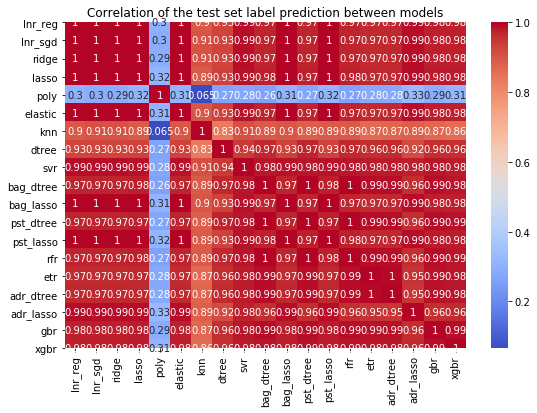

In [63]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [64]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [65]:
print("Least Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Least Absolute Correlations
poly  knn          0.065119
      bag_dtree    0.263609
      rfr          0.265220
      dtree        0.267655
      pst_dtree    0.271280
dtype: float64


### Voting Top 5

In [66]:
from sklearn.ensemble import VotingRegressor

In [67]:
vreg1 = VotingRegressor(estimators=
                              [('xgbr', xgbr_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_), 
                               ('bag_lasso', bag_lasso1_grid.best_estimator_),
                               ('elasticnet', grid_elasticnet.best_estimator_),
                               ('svr', grid_svr.best_estimator_)
                              ], )
vreg1_param = {
              'weights' : [None]
}
vreg1_grid = GridSearchCV(vreg1, vreg1_param,cv=5, return_train_score=True)
vreg1_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {vreg1_grid.best_score_}')
print(f'Best Params {vreg1_grid.best_params_}')
print(f'Train score is {vreg1_grid.score(X_train,y_train)}')
print(f'Test score is {vreg1_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.905462549359424
Best Params {'weights': None}
Train score is 0.9629064272280686
Test score is 0.8957378922373269


### Voting Least Correlated

In [68]:
vreg2 = VotingRegressor(estimators=
                              [('adr_dtree', adr_dtree_grid.best_estimator_), 
                               ('bag_dtree', bag_dtree_grid.best_estimator_),
                               ('rfr', rfc_grid.best_estimator_),
                               ('pst_dtree', paste_dtree1_grid.best_estimator_)
                              ], )
vreg2_param = {
              'weights' : [None]
}
vreg2_grid = GridSearchCV(vreg2, vreg2_param,cv=5, return_train_score=True)
vreg2_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {vreg2_grid.best_score_}')
print(f'Best Params {vreg2_grid.best_params_}')
print(f'Train score is {vreg2_grid.score(X_train,y_train)}')
print(f'Test score is {vreg2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.876999005800681
Best Params {'weights': None}
Train score is 0.9849274131879073
Test score is 0.8687020399011836


In [ ]:
regressors={
             'lnr_reg':lr_gcv,
             'lnr_sgd':grid_sgd,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'poly':grid_poly,
             'elastic':grid_elasticnet,
             'knn':gridknn,
             'dtree':grid_dt,
             'svr':grid_svr,
             'bag_dtree':bag_dtree_grid,
             'bag_lasso':bag_lasso1_grid,
             'pst_dtree':paste_dtree1_grid,
             'pst_lasso':paste_lasso1_grid,
             'rfr':rfc_grid,
             'etr': etc_grid,
             'adr_dtree':adr_dtree_grid,
             'adr_lasso':adc_lasso_grid,
             'gbr': gbr_grid,
             'xgbr': xgbr_grid}

### Stacking Top 5

In [70]:
from sklearn.ensemble import StackingRegressor

Best Mean Cross Validation Score is {'alpha': 0.1, 'colsample_bytree': 0.6, 'gamma': 0.1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.6}

In [77]:
sreg1 = StackingRegressor(estimators=
                              [('xgbr', xgbr_grid.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_), 
                               ('bag_lasso', bag_lasso1_grid.best_estimator_),
#                                ('elasticnet', grid_elasticnet.best_estimator_),
                               ('svr', grid_svr.best_estimator_)
                              ], final_estimator=XGBRegressor(alpha =0.1, colsample_bytree=0.6, gamma=0.1, learning_rate = 0.1,
                                                             max_depth = 6, min_child_weight = 1, n_estimators = 150,
                                                             subsample = 0.6, reg_lambda = 0.1), cv=3)
sreg1_param = {
              'final_estimator__n_jobs' : [-1]
              }
sreg1_param_grid = GridSearchCV(sreg1, sreg1_param,cv=5, return_train_score=True)
sreg1_param_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=3,
                                         estimators=[('xgbr',
                                                      XGBRegressor(alpha=0.1,
                                                                   base_score=0.5,
                                                                   booster=None,
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=0.6,
                                                                   early_stopping_rounds=2,
                                                                   gamma=0.1,
                                                                   gpu_id=-1,
                                                                   importance_type='gain',
          

In [78]:
print(f'Best Mean Cross Validation Score is {sreg1_param_grid.best_score_}')
print(f'Best Params are {sreg1_param_grid.best_params_}')
print(f'Train score is {sreg1_param_grid.score(X_train,y_train)}')
print(f'Test score is {sreg1_param_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8757598547308921
Best Params are {'final_estimator__n_jobs': -1}
Train score is 0.9512090531555423
Test score is 0.8945623243004622


### Stacking Least Correlated

In [79]:
sreg2 = StackingRegressor(estimators=
                              [('adr_dtree', adr_dtree_grid.best_estimator_), 
                               ('bag_dtree', bag_dtree_grid.best_estimator_),
                               ('rfr', rfc_grid.best_estimator_),
                               ('pst_dtree', paste_dtree1_grid.best_estimator_)
                              ], final_estimator=XGBRegressor(alpha =0.1, colsample_bytree=0.6, gamma=0.1, learning_rate = 0.1,
                                                             max_depth = 6, min_child_weight = 1, n_estimators = 150,
                                                             subsample = 0.6, reg_lambda = 0.1), cv=3)
sreg2_param = {
              'final_estimator__n_jobs' : [-1]
              }
sreg2_param_grid = GridSearchCV(sreg2, sreg2_param,cv=5, return_train_score=True)
sreg2_param_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingRegressor(cv=3,
                                         estimators=[('adr_dtree',
                                                      AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                                             criterion='mse',
                                                                                                             max_depth=11,
                                                                                                             max_features=None,
                                                                                                             max_leaf_nodes=None,
                                                                                                             min_impurity_decrease=0.0,
                                                                                   

In [80]:
print(f'Best Mean Cross Validation Score is {sreg2_param_grid.best_score_}')
print(f'Best Params are {sreg2_param_grid.best_params_}')
print(f'Train score is {sreg2_param_grid.score(X_train,y_train)}')
print(f'Test score is {sreg2_param_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.8358407981627947
Best Params are {'final_estimator__n_jobs': -1}
Train score is 0.945114065016067
Test score is 0.8320224667291407
